In [1]:
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
alaska_glaciers = pd.read_csv("RGI2000-v7.0-G-01_alaska-attributes.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'RGI2000-v7.0-G-01_alaska-attributes.csv'

In [3]:
# First, we will get all column names as a list
cols = alaska_glaciers.columns.tolist()  
print(cols)

['rgi_id', 'o1region', 'o2region', 'glims_id', 'anlys_id', 'subm_id', 'src_date', 'cenlon', 'cenlat', 'utm_zone', 'area_km2', 'primeclass', 'conn_lvl', 'surge_type', 'term_type', 'glac_name', 'is_rgi6', 'termlon', 'termlat', 'zmin_m', 'zmax_m', 'zmed_m', 'zmean_m', 'slope_deg', 'aspect_deg', 'aspect_sec', 'dem_source', 'lmax_m']


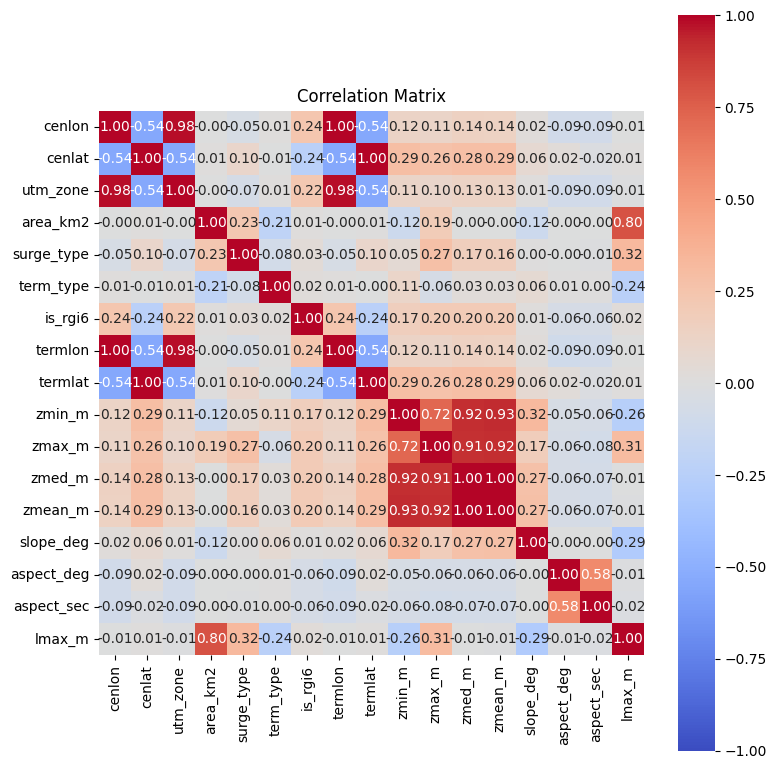

In [4]:
## Correlation coefficient matrix
df_glacier = alaska_glaciers[cols]
df_glacier = df_glacier.drop(columns = ['rgi_id', 'o1region', 'o2region', 'src_date','glac_name','dem_source','glims_id', 'anlys_id', 'subm_id','primeclass','conn_lvl'])
cols = df_glacier.columns
corr_matrix = df_glacier.corr()


fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            vmin=-1, vmax=1, center=0, ax=ax, square=True,
            xticklabels=cols, yticklabels=cols)
plt.tight_layout()
plt.title('Correlation Matrix')
plt.show()

In [5]:
# First, we extract geochemical data and drop rows with NaN values
alaska_glaciers = alaska_glaciers[cols].dropna()
alaska_glaciers = alaska_glaciers.drop(columns = ['zmean_m','zmin_m', 'zmax_m'])
cols = alaska_glaciers.columns

# Let's center the data by subtracting the mean
# Note that we do not *normalize* the data
#geochem_centered = geochem - geochem.mean()

In [6]:
np.shape(alaska_glaciers)

(27509, 14)

Text(0.5, 1.0, 'Histogram of centerline length')

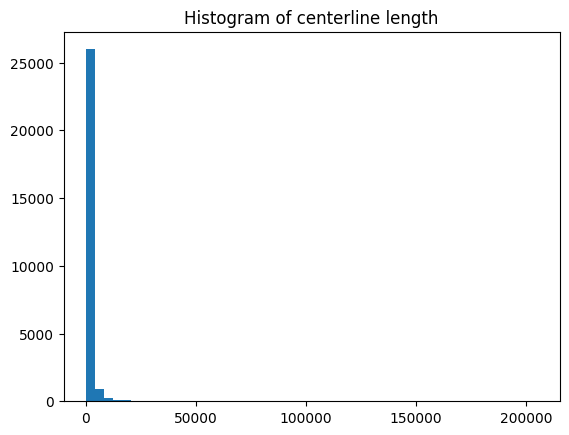

In [7]:
plt.hist(alaska_glaciers['lmax_m'],bins=50)
plt.title('Histogram of centerline length')
#limit lmax_m, remove outlier, subtract the mean

In [8]:
U, S, Vt = np.linalg.svd(alaska_glaciers, full_matrices=False)

# Project data onto principal components (scores)
pca_result = U * S

# Calculate explained variance ratio
explained_variance = (S ** 2) / (len(alaska_glaciers) - 1)
explained_variance_ratio = explained_variance / explained_variance.sum()

# What proportion is variance is explained by each PC?
print("Explained variance:")
for i, var in enumerate(explained_variance_ratio):
    print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")

Explained variance:
  PC1: 0.8933 (89.33%)
  PC2: 0.1056 (10.56%)
  PC3: 0.0009 (0.09%)
  PC4: 0.0001 (0.01%)
  PC5: 0.0000 (0.00%)
  PC6: 0.0000 (0.00%)
  PC7: 0.0000 (0.00%)
  PC8: 0.0000 (0.00%)
  PC9: 0.0000 (0.00%)
  PC10: 0.0000 (0.00%)
  PC11: 0.0000 (0.00%)
  PC12: 0.0000 (0.00%)
  PC13: 0.0000 (0.00%)
  PC14: 0.0000 (0.00%)


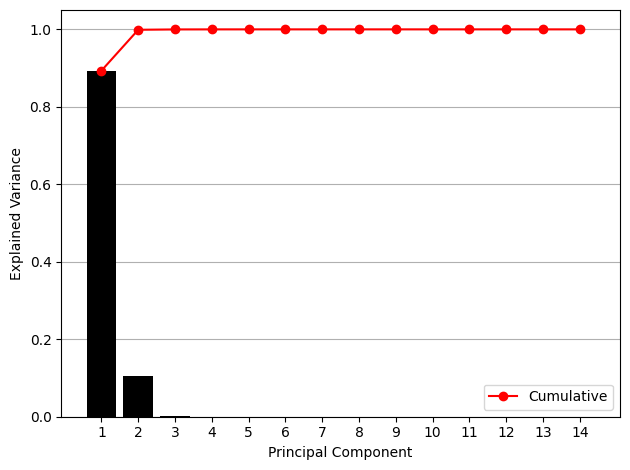

In [9]:
fig, ax = plt.subplots()
ax.bar(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, 
       color='black')
ax.plot(range(1, len(explained_variance_ratio)+1), np.cumsum(explained_variance_ratio), 
        'ro-', label='Cumulative')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
ax.set_xticks(range(1, len(explained_variance_ratio)+1))
ax.legend()
ax.grid(True, axis='y')
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

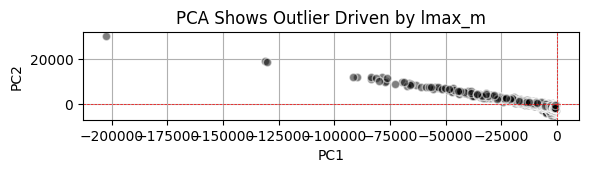

In [10]:
fig, ax = plt.subplots()
ax.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, color='k', edgecolors='w')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.axhline(y=0, color='r', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='r', linestyle='--', linewidth=0.5)

ax.set_aspect('equal')
ax.grid(True)
ax.set_axisbelow(True)
plt.title('PCA Shows Outlier Driven by lmax_m')
plt.show()

In [11]:
loadings = pd.DataFrame(Vt.T, index=cols, columns=[f'PC{i+1}' for i in range(len(cols))])
print("\nLoadings for PC1 and PC2:")
print(loadings[['PC1', 'PC2']])


Loadings for PC1 and PC2:
                 PC1       PC2
cenlon      0.013755  0.078683
cenlat     -0.005817 -0.033492
utm_zone   -0.000667 -0.003888
area_km2   -0.006998  0.007194
surge_type -0.000029 -0.000011
term_type  -0.000854 -0.005028
is_rgi6    -0.000091 -0.000521
termlon     0.013755  0.078683
termlat    -0.005816 -0.033493
zmed_m     -0.153420 -0.974749
slope_deg  -0.001923 -0.014387
aspect_deg -0.017756 -0.103208
aspect_sec -0.000398 -0.002326
lmax_m     -0.987748  0.155827


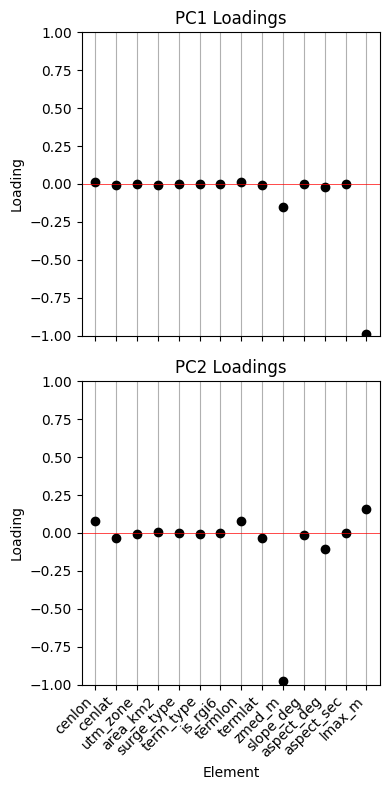

In [12]:
# Why don't we visualize these loadings?
fig, axes = plt.subplots(2, 1, figsize=(4, 8), sharex=True)
x = np.arange(len(cols))


# PC1 loadings
ax1 = axes[0]
ax1.scatter(x, loadings['PC1'], color='black')
ax1.set_ylabel('Loading')
ax1.axhline(y=0, color='r', linestyle='-', linewidth=0.5)
ax1.set_ylim(-1, 1)
ax1.grid(True, axis='x')
ax1.set_axisbelow(True)
ax1.set_title('PC1 Loadings')

# PC2 loadings
ax2 = axes[1]
ax2.scatter(x, loadings['PC2'], color='black')
ax2.set_ylabel('Loading')
ax2.set_xlabel('Element')
ax2.set_xticks(x)
ax2.set_xticklabels(cols, rotation=45, ha='right')
ax2.axhline(y=0, color='r', linestyle='-', linewidth=0.5)
ax2.set_ylim(-1, 1)
ax2.grid(True, axis='x')
ax2.set_axisbelow(True)
ax2.set_title('PC2 Loadings')

plt.tight_layout()
plt.show()

In [13]:
# First, we extract geochemical data and drop rows with NaN values
alaska_glaciers = alaska_glaciers[cols].dropna()
#alaska_glaciers = alaska_glaciers.drop(columns = ['zmean_m'])
cols = alaska_glaciers.columns

# Let's center the data by subtracting the mean
# Note that we do not *normalize* the data
filtered_df = alaska_glaciers[alaska_glaciers['lmax_m'] < 10000]
glaciers_centered = filtered_df - filtered_df.mean()

(array([1257., 4057., 4225., 3580., 2831., 2249., 1569., 1287.,  999.,
         774.,  616.,  497.,  399.,  338.,  282.,  231.,  223.,  198.,
         163.,  124.,  115.,   88.,   95.,   73.,   66.,   56.,   45.,
          44.,   37.,   55.,   45.,   31.,   32.,   27.,   27.,   25.,
          24.,   27.,   29.,   21.,   16.,   18.,   20.,   13.,   19.,
          12.,   10.,   18.,   17.,    9.]),
 array([-1213.86502795, -1015.86502795,  -817.86502795,  -619.86502795,
         -421.86502795,  -223.86502795,   -25.86502795,   172.13497205,
          370.13497205,   568.13497205,   766.13497205,   964.13497205,
         1162.13497205,  1360.13497205,  1558.13497205,  1756.13497205,
         1954.13497205,  2152.13497205,  2350.13497205,  2548.13497205,
         2746.13497205,  2944.13497205,  3142.13497205,  3340.13497205,
         3538.13497205,  3736.13497205,  3934.13497205,  4132.13497205,
         4330.13497205,  4528.13497205,  4726.13497205,  4924.13497205,
         5122.13497205, 

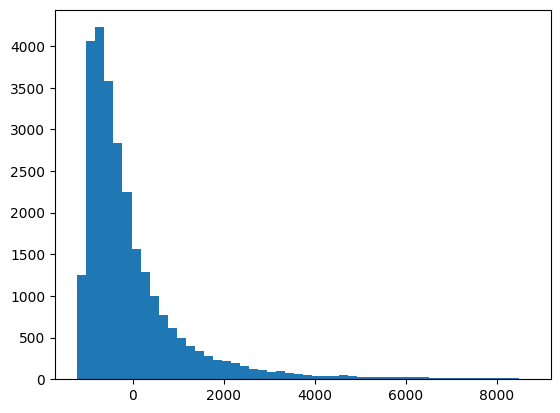

In [14]:
plt.hist(glaciers_centered['lmax_m'],bins=50)

In [15]:
U, S, Vt = np.linalg.svd(glaciers_centered, full_matrices=False)

# Project data onto principal components (scores)
pca_result = U * S

# Calculate explained variance ratio
explained_variance = (S ** 2) / (len(alaska_glaciers) - 1)
explained_variance_ratio = explained_variance / explained_variance.sum()

# What proportion is variance is explained by each PC?
print("Explained variance:")
for i, var in enumerate(explained_variance_ratio):
    print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")

Explained variance:
  PC1: 0.8619 (86.19%)
  PC2: 0.1300 (13.00%)
  PC3: 0.0080 (0.80%)
  PC4: 0.0001 (0.01%)
  PC5: 0.0000 (0.00%)
  PC6: 0.0000 (0.00%)
  PC7: 0.0000 (0.00%)
  PC8: 0.0000 (0.00%)
  PC9: 0.0000 (0.00%)
  PC10: 0.0000 (0.00%)
  PC11: 0.0000 (0.00%)
  PC12: 0.0000 (0.00%)
  PC13: 0.0000 (0.00%)
  PC14: 0.0000 (0.00%)


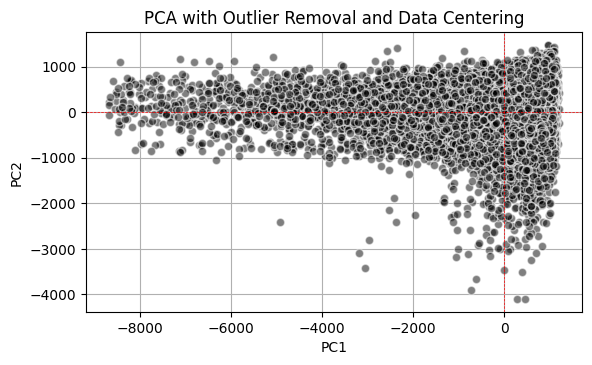

In [16]:
fig, ax = plt.subplots()
ax.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, color='k', edgecolors='w')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.axhline(y=0, color='r', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='r', linestyle='--', linewidth=0.5)

ax.set_aspect('equal')
ax.grid(True)
ax.set_axisbelow(True)
plt.title('PCA with Outlier Removal and Data Centering')
plt.show()

In [17]:
loadings = pd.DataFrame(Vt.T, index=cols, columns=[f'PC{i+1}' for i in range(len(cols))])
print("\nLoadings for PC1 and PC2:")
print(loadings[['PC1', 'PC2']])


Loadings for PC1 and PC2:
                 PC1       PC2
cenlon      0.000054 -0.002443
cenlat      0.000038 -0.001435
utm_zone    0.000013 -0.000385
area_km2   -0.001332  0.000099
surge_type -0.000034 -0.000117
term_type   0.000012 -0.000008
is_rgi6    -0.000009 -0.000107
termlon     0.000054 -0.002444
termlat     0.000037 -0.001435
zmed_m     -0.004473 -0.999845
slope_deg   0.002184 -0.003958
aspect_deg  0.000808  0.016035
aspect_sec  0.000088  0.000404
lmax_m     -0.999986  0.004477


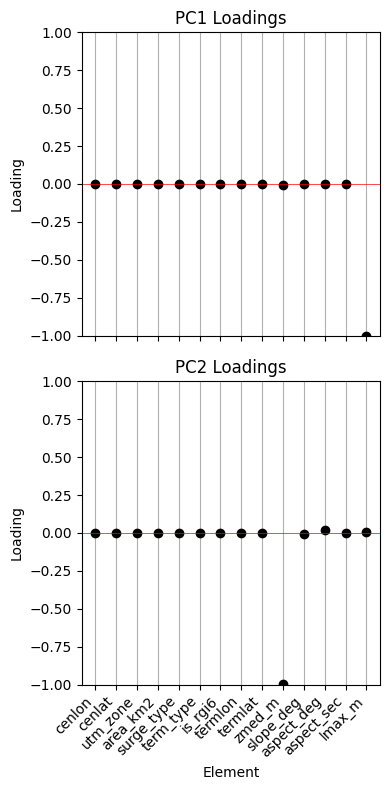

In [18]:
# Why don't we visualize these loadings?
fig, axes = plt.subplots(2, 1, figsize=(4, 8), sharex=True)
x = np.arange(len(cols))


# PC1 loadings
ax1 = axes[0]
ax1.scatter(x, loadings['PC1'], color='black')
ax1.set_ylabel('Loading')
ax1.axhline(y=0, color='r', linestyle='-', linewidth=0.5)
ax1.set_ylim(-1, 1)
ax1.grid(True, axis='x')
ax1.set_axisbelow(True)
ax1.set_title('PC1 Loadings')

# PC2 loadings
ax2 = axes[1]
ax2.scatter(x, loadings['PC2'], color='black')
ax2.set_ylabel('Loading')
ax2.set_xlabel('Element')
ax2.set_xticks(x)
ax2.set_xticklabels(cols, rotation=45, ha='right')
ax2.axhline(y=0, color='r', linestyle='-', linewidth=0.5)
ax2.set_ylim(-1, 1)
ax2.grid(True, axis='x')
ax2.set_axisbelow(True)
ax2.set_title('PC2 Loadings')

plt.tight_layout()
plt.show()

In [19]:
#drop lmax_m, utm_zone, integer
#want area, elevation, slope, aspect ratio

In [20]:
glaciers_centered = glaciers_centered.drop(columns = ['lmax_m','utm_zone','aspect_sec','is_rgi6','term_type','surge_type','cenlon','cenlat','termlon','termlat'])

cols = glaciers_centered.columns

In [21]:
U, S, Vt = np.linalg.svd(glaciers_centered, full_matrices=False)

# Project data onto principal components (scores)
pca_result = U * S

# Calculate explained variance ratio
explained_variance = (S ** 2) / (len(alaska_glaciers) - 1)
explained_variance_ratio = explained_variance / explained_variance.sum()

# What proportion is variance is explained by each PC?
print("Explained variance:")
for i, var in enumerate(explained_variance_ratio):
    print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")

Explained variance:
  PC1: 0.9416 (94.16%)
  PC2: 0.0582 (5.82%)
  PC3: 0.0002 (0.02%)
  PC4: 0.0000 (0.00%)


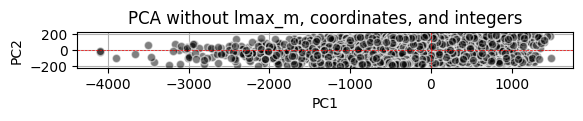

In [22]:
fig, ax = plt.subplots()
ax.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, color='k', edgecolors='w')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.axhline(y=0, color='r', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='r', linestyle='--', linewidth=0.5)

ax.set_aspect('equal')
ax.grid(True)
ax.set_axisbelow(True)
plt.title('PCA without lmax_m, coordinates, and integers')
plt.show()

In [23]:
loadings = pd.DataFrame(Vt.T, index=cols, columns=[f'PC{i+1}' for i in range(len(cols))])
print("\nLoadings for PC1 and PC2:")
print(loadings[['PC1', 'PC2']])


Loadings for PC1 and PC2:
                 PC1       PC2
area_km2    0.000060  0.000257
zmed_m     -0.999864 -0.016054
slope_deg  -0.003893 -0.000570
aspect_deg  0.016056 -0.999871


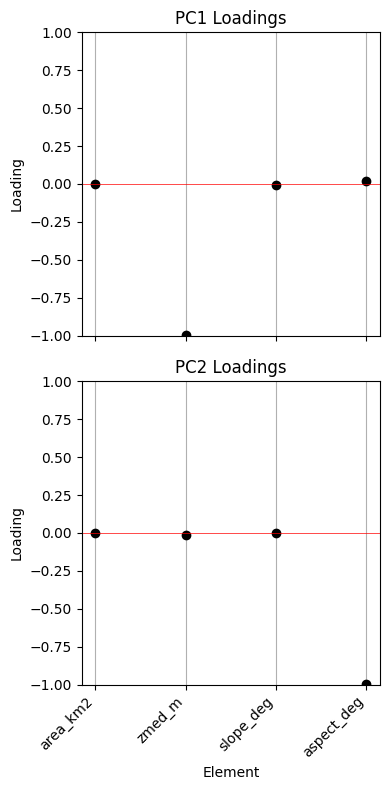

In [24]:
# Why don't we visualize these loadings?
fig, axes = plt.subplots(2, 1, figsize=(4, 8), sharex=True)
x = np.arange(len(cols))


# PC1 loadings
ax1 = axes[0]
ax1.scatter(x, loadings['PC1'], color='black')
ax1.set_ylabel('Loading')
ax1.axhline(y=0, color='r', linestyle='-', linewidth=0.5)
ax1.set_ylim(-1, 1)
ax1.grid(True, axis='x')
ax1.set_axisbelow(True)
ax1.set_title('PC1 Loadings')

# PC2 loadings
ax2 = axes[1]
ax2.scatter(x, loadings['PC2'], color='black')
ax2.set_ylabel('Loading')
ax2.set_xlabel('Element')
ax2.set_xticks(x)
ax2.set_xticklabels(cols, rotation=45, ha='right')
ax2.axhline(y=0, color='r', linestyle='-', linewidth=0.5)
ax2.set_ylim(-1, 1)
ax2.grid(True, axis='x')
ax2.set_axisbelow(True)
ax2.set_title('PC2 Loadings')
plt.tight_layout()
plt.show()